In [2]:
import torch
import torchvision

from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

# Download Data

In [3]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100.0%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
class_names = train_data.classes

class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
class_to_idx = train_data.class_to_idx

class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [7]:
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

image.shape: torch.Size([1, 28, 28])


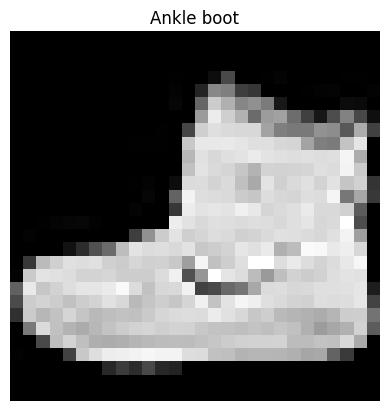

In [12]:
image, label = train_data[0]

print('image.shape:', image.shape)

plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis('off')
plt.show()

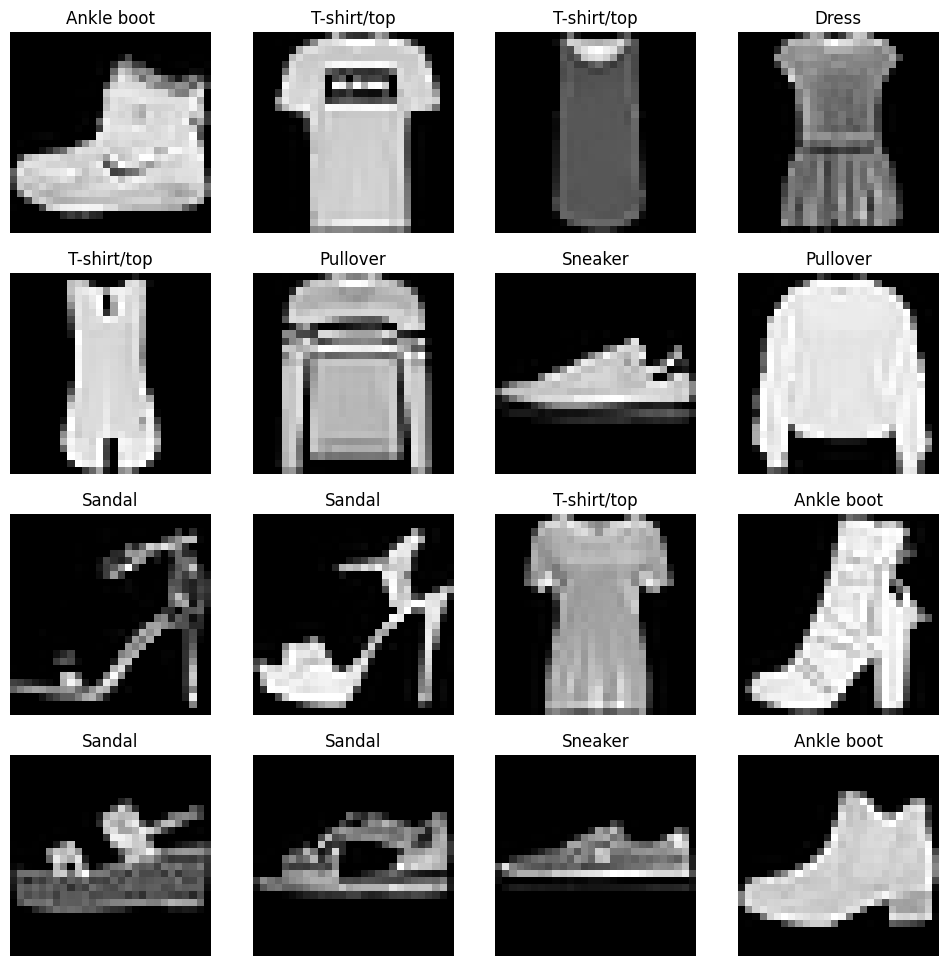

In [ ]:
plt.figure(figsize=(12, 12))

for i in range(16):
    image, label = train_data[i]
    plt.subplot(4, 4, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')

# DataLoader

In [16]:
from torch.utils.data import DataLoader

In [17]:
BATCH_SIZE = 32

In [18]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False
)

In [20]:
train_dataloader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [23]:
len(train_dataloader), len(train_dataloader) * BATCH_SIZE

(1875, 60000)

In [24]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [28]:
torch.manual_seed(42)
rand_idx = torch.randint(0, len(train_features_batch), size=[1]).item()

In [29]:
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]

In [33]:
img.shape

torch.Size([1, 28, 28])

In [34]:
img.squeeze().shape

torch.Size([28, 28])

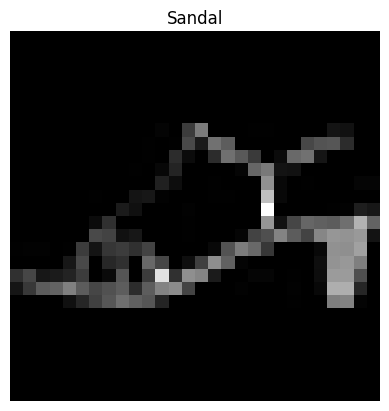

In [31]:
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label.item()])
plt.axis('off')
plt.show()

# Build a baseline model

In [35]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

In [36]:
x.shape, output.shape

(torch.Size([1, 28, 28]), torch.Size([1, 784]))

In [37]:
from torch import nn

class FashionMNISTModel(nn.Module):
    def __init__(
            self,
            input_shape: int,
            hidden_units: int,
            output_shape: int
    ):
        super(FashionMNISTModel, self).__init__()

        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=input_shape,
                out_features=hidden_units
            ),
            nn.Linear(
                in_features=hidden_units,
                out_features=output_shape
            )
        )

    def forward(self, x):
        return self.layer_stack(x)

In [56]:
torch.manual_seed(42)

model_0 = FashionMNISTModel(
    input_shape=28 * 28, # 784
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

In [39]:
dummy_x = torch.rand([1, 1, 28, 28])

model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

## Setup loss, optimizer and evaluation metrics

In [51]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / len(y_pred)) * 100

    return acc

loss_fn = nn.CrossEntropyLoss()
optmizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [44]:
from timeit import default_timer as timer

def print_train_time(
    start: float,
    end: float,
    device: torch.device = None
):
    total_time = end - start

    print(f"Training time on {device}: {total_time:.3f} seconds")

    return total_time

In [45]:
start_time = timer()

end_time = timer()

print_train_time(start_time, end_time, "cpu")

Training time on cpu: 0.000 seconds


1.666200114414096e-05

## Creating a training loop

In [54]:
from tqdm import tqdm

torch.manual_seed(42)

In [ ]:
train_time_start_cpu = timer()

EPOCHS = 10

for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch {epoch}\n--------------------------------------------------------------------------")

    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()

        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)

        train_loss += loss

        optmizer.zero_grad()

        loss.backward()

        optmizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

    train_loss /= len(train_dataloader)

    test_loss, test_acc = 0, 0

    model_0.eval()

    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            test_pred = model_0(X_test)

            test_loss += loss_fn(test_pred, y_test)

            test_acc += accuracy_fn(test_pred.argmax(dim=1), y_test)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")
    print("--------------------------------------------------------------------------\n")


train_time_end_cpu = timer()

print_train_time(train_time_start_cpu, train_time_end_cpu, str(next(model_0.parameters()).device))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0
------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 10%|█         | 1/10 [00:05<00:52,  5.88s/it]


Train loss: 2.3185 | Test loss: 2.3191 | Test accuracy: 10.8526
------------------------------------------------------

Epoch 1
------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 20%|██        | 2/10 [00:11<00:47,  5.99s/it]


Train loss: 2.3185 | Test loss: 2.3191 | Test accuracy: 10.8526
------------------------------------------------------

Epoch 2
------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 30%|███       | 3/10 [00:18<00:42,  6.09s/it]


Train loss: 2.3185 | Test loss: 2.3191 | Test accuracy: 10.8526
------------------------------------------------------

Epoch 3
------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 40%|████      | 4/10 [00:24<00:37,  6.30s/it]


Train loss: 2.3185 | Test loss: 2.3191 | Test accuracy: 10.8526
------------------------------------------------------

Epoch 4
------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 50%|█████     | 5/10 [00:31<00:31,  6.34s/it]


Train loss: 2.3185 | Test loss: 2.3191 | Test accuracy: 10.8526
------------------------------------------------------

Epoch 5
------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 60%|██████    | 6/10 [00:37<00:25,  6.28s/it]


Train loss: 2.3185 | Test loss: 2.3191 | Test accuracy: 10.8526
------------------------------------------------------

Epoch 6
------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 70%|███████   | 7/10 [00:43<00:18,  6.16s/it]


Train loss: 2.3185 | Test loss: 2.3191 | Test accuracy: 10.8526
------------------------------------------------------

Epoch 7
------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 80%|████████  | 8/10 [00:49<00:12,  6.07s/it]


Train loss: 2.3185 | Test loss: 2.3191 | Test accuracy: 10.8526
------------------------------------------------------

Epoch 8
------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


 90%|█████████ | 9/10 [00:54<00:05,  5.99s/it]


Train loss: 2.3185 | Test loss: 2.3191 | Test accuracy: 10.8526
------------------------------------------------------

Epoch 9
------------------------------------------------------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.


100%|██████████| 10/10 [01:00<00:00,  6.09s/it]


Train loss: 2.3185 | Test loss: 2.3191 | Test accuracy: 10.8526
------------------------------------------------------

Training time on cpu: 60.883 seconds


60.88311570198857